### Preparing the notebook

In [1]:
from utilities.helpers import check

check()

/home/selimsepthuit/anaconda3/envs/test-ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow version 	= 1.7 [ok]
Keras version 		= 2.1 [ok]
OpenCV version 		= 3.3 [ok]

1 GPU detected


In [137]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
from utilities.helpers import Time

In [102]:
# # # Jupyter will automaticaly reload libraries if they have been modified
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Table of Contents
---
- [Data](# Data)
    - Loading and pre-processing the dataset
    - Visualizing the dataset
    
- [Training/Loading the model](# Training/Loading the model)
- [Evaluating the model](# Evaluating the model)

# Data
---

## Loading and pre-processing the dataset

The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/).

This dataset contains images with and without persons.

Loading the data ...
- ... transforms images into a 4D tensor of shape `(samples_size, 224, 224, 3)` suitable for supplying to a Keras CNN
- ... transform class labels into one hot encoded labels.
- ... creates a validation folder using 20% of the original training data (The INRIA person dataset originaly doesn't contain validation data)

The training tensors and labels can be accessed as follows:
```
data.X_train
data.y_train
```
Same goes for the validation and testing data (`X_valid`, `y_test` etc.)

In [5]:
from utilities import datasets

data = datasets.InriaPersonDataset("INRIAPerson")

100%|██████████| 545/545 [00:05<00:00, 98.54it/s] 


## Visualizing the dataset

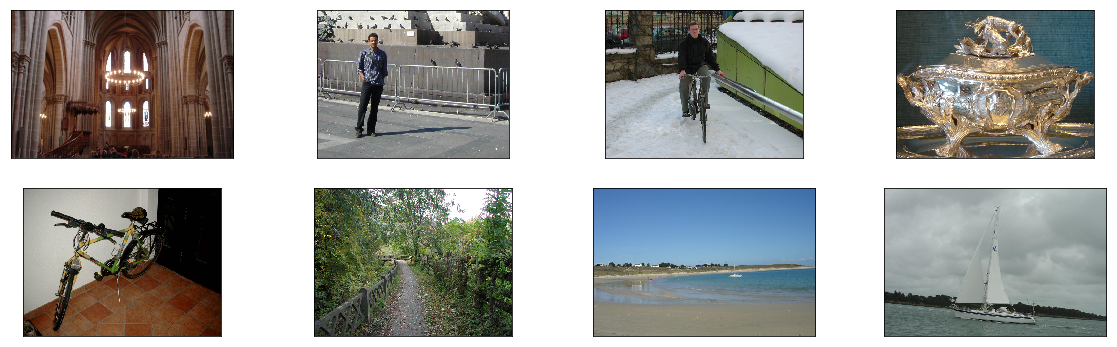

In [6]:
data.examples(sample="Test", number=8)

In [7]:
data.classes

['neg', 'pos']

In [8]:
data.statistics()

,neg,pos,Total
Classes,,,
Train,860,423,1283
Valid,356,189,545
Test,453,288,741
,1669,900,2569


# Training the model
---

### Model

In [59]:
from utilities.gapModels import MobileNetGAP

The `MobileNetGAP` class can be used just as any **compiled** Keras model (`keras.models`). 

This model is a the MobileNet model, top not included, that ends with a GlobalAveragePooling layer, followed by a dense layer with as many neurones as there are classes in the dataset.

The ConvNet layers of the model have been pretrained on the [ImageNet](http://image-net.org) dataset.

We will perform **transfert learning** by training the dense layer and retraining only the last two convnet layers (as the database is quite small).

Once trained it will be possible to load the model by simply calling:
```
model = MobileNetGAP(path='saved_model/mobilenet.h5')
```

Let's now create the compiled model:

In [60]:
model = MobileNetGAP(nb_classes=len(data.classes))

### Classifier

In [104]:
from utilities.classifier import Classifier

To train the model and save it, we will create an instance of the `Classifier` class.


A classifier takes as parameter a model, preferably built with a subclass of `AbstractModelGAP` (see `./utilities/gapModels.py`) as this will make the generation of CAMs easier.

Classifiers can be fitted to a dataset (which will train the model given as parameter).

Once fitted, they can be used to predict the class of an image or to generate **Class Activation Maps** (CAM)

Classifiers can also be used with a pretrained model loaded with `MobileNetGAP(path)`. They then can, but don't need to be fitted again to generate predictions/CAMs.


In [ ]:
clf = Classifier(model, name='mobilenet')

clf.fit(data, epochs=20, batch_size=32, augmentation=False, verbose=1)

Train on 1283 samples, validate on 545 samples
Epoch 1/20
1283/1283 [==============================] - 12s 9ms/step - loss: 0.0253 - acc: 0.9977 - val_loss: 0.0486 - val_acc: 0.9927

Epoch 00001: val_loss improved from inf to 0.04863, saving model to saved_model/mobilenet.h5
Epoch 2/20
1283/1283 [==============================] - 11s 9ms/step - loss: 0.0248 - acc: 0.9961 - val_loss: 0.0548 - val_acc: 0.9853

Epoch 00002: val_loss did not improve
Epoch 3/20
1283/1283 [==============================] - 11s 9ms/step - loss: 0.0564 - acc: 0.9883 - val_loss: 0.0720 - val_acc: 0.9817

Epoch 00003: val_loss did not improve
Epoch 4/20
1283/1283 [==============================] - 11s 9ms/step - loss: 0.0357 - acc: 0.9914 - val_loss: 0.1039 - val_acc: 0.9706

Epoch 00004: val_loss did not improve
Epoch 5/20
1283/1283 [==============================] - 11s 9ms/step - loss: 0.0566 - acc: 0.9829 - val_loss: 0.1481 - val_acc: 0.9450

Epoch 00005: val_loss did not improve
Epoch 6/20
1283/1283 [======

# Evaluating the model
---

Let's visualise the learning curves:

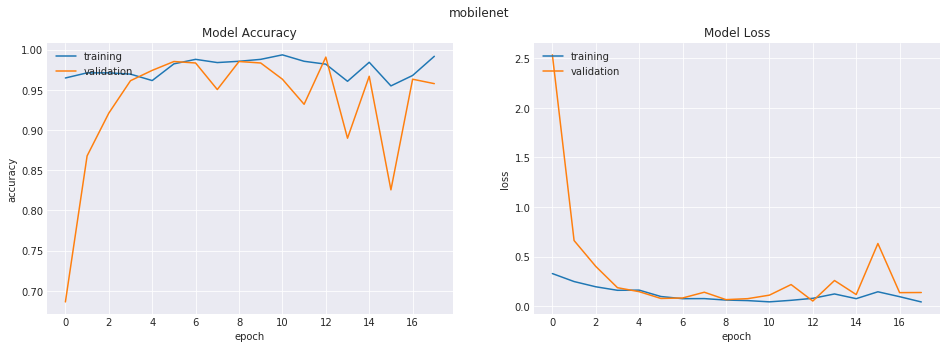

In [173]:
clf.learning_curves()

>These can also be visualized with Tensorboar:
```
tensorboard --logdir=./tensorboard_logs
```
The Tensorboard page can then be found on port `6006`  

We get the following results on the test set:

In [174]:
loss, acc = model.evaluate(data.X_test, data.y_test)

741/741 [==============================] - 2s 2ms/step


In [175]:
print("Loss     : {:.2%}\nAccuracy : {:.2%}".format(loss, acc))

Loss     : 36.49%
Accuracy : 91.36%


# Results
---

Let's view the results for an exemple:

In [176]:
test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
test_image_path

'INRIAPerson/Test/pos/crop_000005.png'

In [177]:
test_img = cv2.imread(test_image_path, 1)

## Prediction

We can choose to allow the classifier to make a descision on the class or to just show the probabilities:

In [178]:
with Time() as runtime:
    prediction = clf.predict(test_img, decision=False)

print("Prediction     :", prediction)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

Prediction     : [0.00052878726, 0.99947125]
Execution time : 12.635ms


The model got the class right :)

# Generating the Class Activation Maps
---

In [179]:
# Here we could import a previously saved model
# model = MobileNetGAP(path='saved_model/mobilenet.h5')
# clf = Classifier(model, name='mobilenet')

We can now view the regions that allowed the model to estimate the class probabilities:

Execution time : 23.710ms


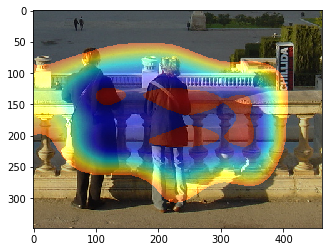

In [181]:
with Time() as runtime:
    cam, prediction = clf.cam(test_img, class_number=1)
    
plt.imshow(cam)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

The CAM generation is quite fast 😎

Let's do that for a few other images:

In [189]:
def cam():
    """
    cam for a random image
    """
    with Time() as runtime:
        test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
        test_img        = cv2.imread(test_image_path, 1)
        cam, prediction = clf.cam(test_img, class_number=1)
    
    print('Execution time : {:.3f}ms'.format(1000*runtime()))
    print("Prediction     :", data.classes[np.argmax(prediction)])
    plt.imshow(cam)

Execution time : 38.334ms
Prediction     : neg


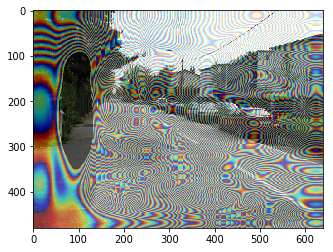

In [197]:
cam()

Execution time : 44.466ms
Prediction     : pos


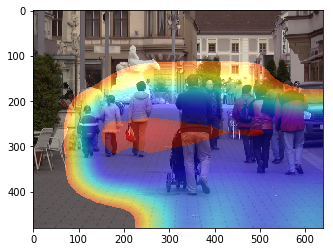

In [198]:
cam()

Execution time : 48.852ms
Prediction     : neg


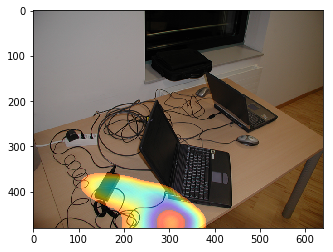

In [199]:
cam()

Execution time : 25.668ms
Prediction     : neg


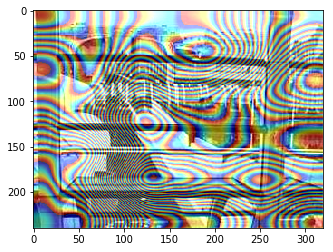

In [201]:
cam()